IMPORT ALL THE REQUIRED LIBRARIES 

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse
import nltk
import os
import json
import math
import csv
import re
import time
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from collections import Counter
! pip install surprise
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp39-cp39-linux_x86_64.whl size=3195810 sha256=c73f299f236f9eb1da7d0c0e0eed1e76592f7ae61c9282af0a37e48878a9597a
  Stored in directory: /root/.cache/pip/wheels/c6/3a/46/9b17b3512bdf283c6cb84f59929cdd5199d4e754d596d22784
Successfully built scikit-surprise


DATA PREPROCESSING
READ THE DATASET AND NAME THE SELECTED COLUMNS IN CORRECT FORMAT

In [41]:
# DATE PREPROCESSING
# Accessing the dataset and picking 
elect_data = pd.read_csv('electronics_dataset.csv')


# Exploratory Data Analysis to show some information about the overall dataset

# view the first ten columns from the dataset
# elect_data.head(10)

# view the number of rows and columns in the dataset
# elect_data.shape

# view the datatypes of the data columns present in the dataset
# elect_data.dtypes()

# view the other information about the dataset
# elect_data.describe()
# elect_data.info()

# elect_data.head(10)
print(elect_data.columns)



Index(['id', 'asins', 'brand', 'categories', 'colors', 'dateAdded',
       'dateUpdated', 'dimension', 'ean', 'imageURLs', 'keys', 'manufacturer',
       'manufacturerNumber', 'name', 'primaryCategories', 'reviews.date',
       'reviews.dateSeen', 'reviews.doRecommend', 'reviews.numHelpful',
       'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.username', 'sourceURLs', 'upc', 'weight'],
      dtype='object')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#create a new datset with only the columns that are highly correlated and relevant to the analysis
new_df = elect_data[['id','brand','categories',"reviews.rating","reviews.text",'reviews.username']]
print(type(new_df))

# Exploratory Data Analysis to show some information about the new dataset

# view the first ten columns from the dataset
new_df.head(10)

# view the number of rows and columns in the dataset
# new_df.shape

# view the datatypes of the data columns present in the dataset
# new_df.dtypes

# view the other information about the dataset
# THE distribution of the ratings which are numerical varaibles
# new_df.describe()
# new_df.info()


THE DATASET HAS SOME NULL VALUES THAT ARE NOT IMPORTANT FOR OUR ANALYSIS. SO WE ANALYZE THE DISTRIBUTION OF THE NULL VALUES ACROSS THE COLUMNS 

id                    0
brand                 0
categories            0
reviews.rating      164
reviews.text          5
reviews.username      0
dtype: int64

<Axes: >

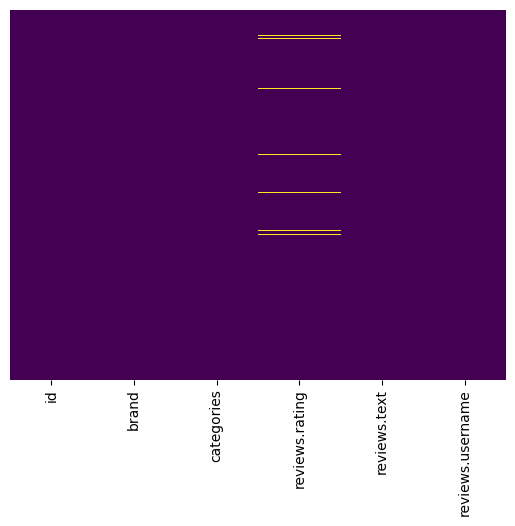

In [ ]:
# check for null values in the dataset and store in a variable 
null_colls = new_df.isnull()
null_colls.sum()

# visializing the null values in the dataset with a heatmap
sns.heatmap(null_colls,yticklabels=False,cbar=False,cmap='viridis')



# Replacing the null values with the mean of the column
# for col in num_col:
#     elect_data[col] = pd.to_numeric(elect_data[col])
#     elect_data[col] = elect_data[col].fillna(elect_data[col].mean(), inplace=True)

# elect_data.head()

# Replace the null values with the 'NaN' string
# for col in null_col:
#     elect_data[col] = elect_data[col].fillna('NaN', inplace=True)

# print(elect_data.head(10))


# # Drop the columns with the highest number of null values as they are irrelevant to the analysis
# elect_data.drop(null_col, axis=1, inplace=True)

# print(elect_data.head(5))




# new_df.to_csv('new_electronics_dataset.csv', index=False)

VIEW THE DISTRIBUTION OF THE RATINGS ACROSS THE ELECTRONIC PRODUCTS

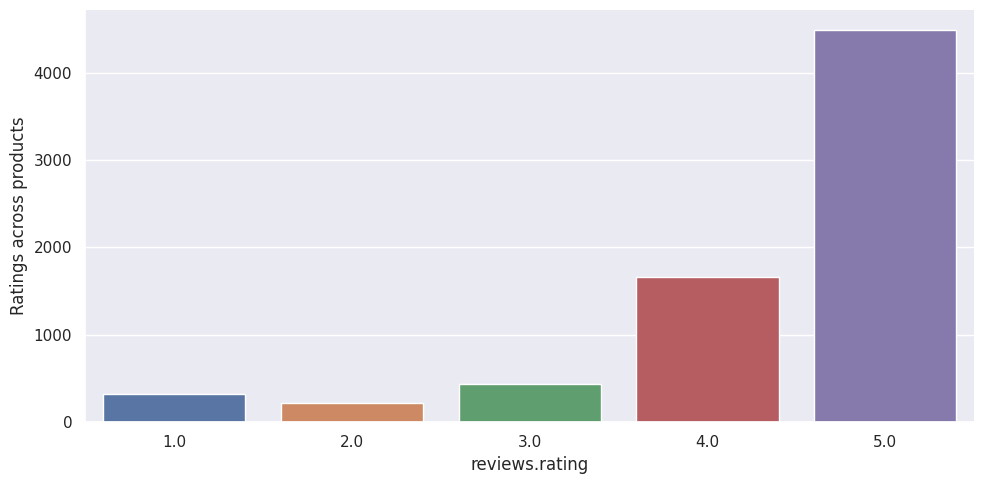

In [ ]:

# set the theme style for the seaborn plot
sns.set_theme(style="darkgrid")

# plot the ratings column on the x axis
fig = sns.catplot(data=new_df, x="reviews.rating",aspect=2.0, kind='count')
fig.set_ylabels("Ratings across products")
    

In [ ]:
# plt.figure(figsize=(10,10))

# # create a correlation matrix of the dataset
# data_corr = df.corr()
# sns.heatmap(data_corr, annot=True, cmap="Blues")

WE CAN SEE THAT THE DISTRIBUTION OF THE RATINGS IS NOT EVEN. SOME PRODUCTS HAVE MORE RATINGS THAN OTHERS. THIS IS BECAUSE SOME USERS HAVE RATED MULTIPLE PRODUCTS AND VICE-VERSA SO WE NEED TO CHECK THE NUMBER OF UNIQUE USERS WHO HAVE RATED THE PRODUCTS AND ALSO THE NUMBER OF UNIQUE PRODUCTS THAT HAVE BEEN RATED BY THE USERS


In [ ]:
# find the unique user reviews
unique_user_reviews = np.unique(new_df['reviews.username'])

# find the length of the unique user reviews
len_unique_user_reviews = len(unique_user_reviews)

print("The number of actual users in the dataset is: ", len_unique_user_reviews)

# find the unique products
unique_products = np.unique(new_df['id'])

# find the number of unique products
no_unique_products = len(unique_products)

print("The number of unique products in the dataset is: ", no_unique_products)




The number of actual users in the dataset is:  6493
The number of unique products in the dataset is:  50


TO TRAIN THE MODEL, THE REVIIEWS TEXT NEEDS TO BE PREPROCESSED AND CONVERTED INTO A SUITABLE FORMAT FOR THE COMPUTER TO USE IT.

In [ ]:
# store the users' reviews in a variable
user_reviews = elect_data['reviews.text']

reviews_text = elect_data.iloc[: , [21]]

# The reviews text are contained in the 21st column of the dataset so all the other columns will be dropped
print(reviews_text)


                                           reviews.text
0     This keyboard is very easy to type on, but the...
1     It's thin and light. I can type pretty easily ...
2     I love the new design the keys are spaced well...
3     Attached easily and firmly. Has a nice feel. A...
4     Our original keyboard was okay, but did not ha...
...                                                 ...
7294  This remote was a decent replacement for my lo...
7295  This looks good on my celling. Flushes very we...
7296  Great Plate for projector mount, very easy to ...
7297  This mount worked very well for me when I used...
7298  It's a nice solid mounting plate check and mak...

[7299 rows x 1 columns]


In [ ]:
# create two files to store the input dataset and resulting output dataset
data_input = "electronics_dataset.csv"
data_output = "output_data.csv"

# create a new dataframe with only the reviews text column and store it in a csv file
df = elect_data.loc[: , ["reviews.text"]]
df.to_csv('output_data.csv', index=False)




# cols_to_remove = [0, 1, 2, 3, 4, 5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,25,26]

# cols_to_remove = sorted(cols_to_remove, reverse=True) # Reverse so we remove from the end first
# row_count = 0 # Current amount of rows processed

# with open(data_input, "r") as source:
#     reader = csv.reader(source)
#     with open(data_output, "w", newline='') as result:
#         writer = csv.writer(result)
#         for row in reader:
#             row_count += 1
#            # print('\r{0}'.format(row_count), end='') # Print rows processed
#             for col_index in cols_to_remove:
#                 del row[col_index]
#             writer.writerow(row)



In [ ]:
# CONVERT THE REVIEWS CSV FILE INTO A TEXT FILE

In [ ]:
with open ("reviews.txt", "w", encoding="utf-8") as new_file:
    writer = csv.writer(new_file)
    # for val in df["reviews.text"]:
    #     writer.writerow([val])
    
    with open("output_data.csv", encoding="utf-8") as old_file:
        for row in csv.reader(old_file):
            writer.writerow(row)
    
    # with open("output_data.csv") as old_file:
    #     [new_file.write(" ".join(row)+'\n') for row in csv.reader(old_file)]

    # new_file.close()

14

132

54

137

75

157

112

80

179

117

212

52

128

654

112

69

68

96

626

66

419

77

263

349

102

59

128

66

103

111

60

211

86

222

174

94

107

56

123

213

75

94

191

324

401

629

73

54

104

222

86

160

66

722

106

221

104

264

267

76

528

165

54

207

113

172

121

308

142

91

93

86

58

323

695

451

212

463

59

82

206

541

482

83

104

67

198

58

108

191

75

432

56

123

381

263

200

138

146

110

313

177

52

149

105

62

60

137

223

207

266

147

87

99

57

75

98

118

573

157

136

113

102

85

176

208

221

67

1260

991

121

72

219

277

107

73

155

53

92

61

57

79

94

168

68

144

110

511

332

73

278

80

114

114

56

137

192

194

109

636

100

536

65

264

167

68

77

68

99

161

89

102

81

257

58

116

287

206

387

71

115

297

266

325

132

358

52

139

176

139

214

106

74

231

93

108

272

669

149

133

84

185

55

265

569

126

61

144

52

76

77

147

65

176

92

65

202

99

90

54

186

153

240

188

52

215

76

97

102

159

246

69

111

82

57

77

64

160

224

122

84

258

57

69

166

113

74

227

247

545

74

582

136

784

102

66

82

75

71

149

148

102

117

96

89

305

74

76

59

193

159

99

62

76

92

164

163

227

89

200

116

96

63

92

144

228

250

90

383

54

129

65

67

104

118

105

303

139

2480

381

225

67

169

75

54

73

115

53

107

155

65

58

117

118

207

322

66

55

193

131

177

161

137

66

349

65

61

228

114

115

88

194

831

96

99

117

156

149

346

126

68

159

131

194

95

79

208

308

63

159

52

69

217

73

703

164

191

153

203

112

201

193

202

209

72

186

124

141

64

265

55

93

273

129

239

153

163

79

89

234

69

151

595

473

95

86

201

188

75

133

387

85

128

86

59

193

101

224

516

56

83

79

251

66

476

144

60

116

55

88

118

133

60

110

321

185

195

219

53

105

70

153

131

72

251

212

218

215

94

36

153

121

154

94

55

91

660

1208

895

956

511

86

291

56

22

171

1095

394

35

874

112

519

550

818

55

505

90

86

403

185

370

105

1243

238

116

316

334

646

408

415

625

602

593

225

631

572

305

186

94

390

373

1570

70

421

421

343

231

301

144

228

182

131

65

269

97

302

481

323

232

471

962

635

1722

1735

1735

471

471

1722

145

323

76

192

141

242

224

181

121

218

457

433

359

118

47

262

821

54

82

82

997

215

66

377

83

149

52

67

152

956

433

55

4

70

217

276

52

227

499

88

425

1708

62

135

59

89

151

997

200

55

734

185

243

703

181

320

99

557

227

122

115

301

283

39

282

156

286

65

301

126

82

84

508

1708

821

103

703

70

210

133

557

115

254

404

131

108

74

131

180

1527

63

94

132

103

29

230

217

100

201

146

63

87

2872

45

63

155

215

89

305

249

76

430

378

58

68

157

117

194

645

40

68

2397

104

123

121

118

179

145

231

21

66

110

30

121

50

994

102

122

1208

79

202

204

147

530

68

105

585

196

226

52

190

382

175

136

185

171

1296

548

107

400

554

357

121

124

2541

1625

56

129

275

93

201

89

67

254

113

280

123

178

297

663

192

101

208

167

330

119

114

143

215

57

54

75

248

57

112

162

74

122

558

406

175

66

189

79

556

572

161

329

404

435

126

125

387

352

213

691

205

272

959

37

126

93

301

337

71

201

31

168

287

62

254

207

1591

704

281

131

64

81

229

528

88

348

78

72

109

60

2317

2206

112

2657

2932

2674

1742

125

598

420

5297

668

753

1412

99

195

461

78

663

111

135

3503

711

987

95

3955

1350

60

1499

208

1726

1334

392

381

60

1393

66

813

78

440

828

957

270

2248

66

61

285

115

269

166

1200

1136

59

931

158

3235

1282

65

2902

166

9305

220

506

161

268

54

65

87

54

1585

455

126

57

71

465

175

1892

3073

129

1702

65

1222

416

1319

2417

1805

74

2643

639

4291

1710

149

1362

263

6583

71

103

1766

546

316

340

354

481

322

101

110

769

61

119

164

147

110

260

172

105

54

80

55

232

192

70

77

178

415

94

81

263

313

80

416

67

70

120

135

278

110

298

102

137

623

115

65

949

87

196

690

69

269

225

65

67

115

52

250

80

63

81

247

183

123

356

259

171

96

68

88

165

171

252

151

161

254

53

102

73

604

170

325

335

259

140

80

166

259

70

168

257

73

127

235

691

229

256

63

114

156

86

169

283

569

92

144

126

1655

502

354

1190

734

602

604

173

509

203

239

204

109

184

437

61

459

182

56

141

72

190

120

182

59

353

692

1640

1701

1640

1640

1886

1172

1886

1690

292

1172

1672

1886

260

149

243

125

60

60

52

241

75

255

242

274

69

80

163

243

59

439

195

114

694

53

63

64

1129

65

100

136

232

209

57

116

76

316

73

174

147

65

115

64

77

271

63

88

129

55

70

111

405

95

67

169

54

59

68

58

76

377

54

263

54

339

79

104

76

66

52

233

81

197

259

162

90

56

63

212

79

168

56

64

109

54

351

117

142

219

116

91

117

125

69

115

300

105

276

188

119

242

148

78

239

107

132

171

52

406

190

62

120

219

57

61

61

213

231

94

145

64

91

59

52

82

67

65

192

125

92

71

70

137

57

163

276

466

331

122

78

178

90

97

67

57

314

206

189

149

70

56

94

179

368

69

70

86

100

53

69

54

98

78

65

65

94

81

194

111

97

99

121

89

100

101

196

82

70

126

57

141

186

170

202

95

63

110

117

87

75

113

154

77

168

60

72

77

193

163

75

52

173

117

143

67

95

117

52

95

186

116

277

72

154

160

75

1022

199

122

66

60

92

295

70

77

89

76

232

93

226

107

71

69

54

52

52

89

75

81

101

98

135

73

61

59

125

227

223

117

54

71

335

65

56

54

60

111

63

141

133

152

141

145

105

118

63

97

143

70

84

1024

407

278

110

444

313

252

168

194

237

98

384

579

86

122

142

139

54

59

231

109

98

121

189

115

102

196

109

82

63

190

74

70

222

154

80

72

81

73

99

629

88

110

52

136

129

66

66

313

93

121

452

75

309

81

77

129

93

87

447

52

53

99

119

185

166

55

53

135

85

90

277

66

61

90

198

92

62

187

60

296

58

98

88

92

58

111

140

60

171

187

187

153

150

273

67

175

143

99

262

94

96

62

83

67

273

77

380

86

62

122

117

61

52

456

52

73

79

197

105

151

60

111

222

179

181

280

83

262

91

93

59

68

76

366

253

76

54

104

104

77

886

507

1553

1657

766

1637

1569

774

248

558

34

239

199

164

120

72

310

125

407

212

246

791

52

109

80

261

52

302

72

297

116

101

119

610

116

59

134

60

120

147

541

54

190

465

59

85

64

55

74

518

111

543

347

424

83

141

129

135

76

68

181

94

52

112

87

145

65

102

75

65

65

72

78

147

458

640

234

65

119

87

852

167

131

61

95

59

165

102

116

312

57

121

549

68

134

140

210

53

100

154

73

149

106

61

125

94

317

58

328

76

61

282

151

53

86

79

88

128

53

119

73

127

469

246

114

218

127

401

197

63

151

77

254

300

186

64

301

60

61

91

94

73

819

175

220

607

1466

204

591

240

58

183

338

73

54

58

100

67

59

433

61

800

58

102

268

381

69

83

230

133

281

56

56

668

55

211

120

642

52

123

102

167

65

92

90

105

168

645

73

63

256

61

93

161

160

122

94

135

132

75

75

357

91

93

250

79

63

74

53

97

87

178

60

98

200

154

56

522

102

52

72

87

64

137

160

52

90

77

295

137

101

127

217

139

54

69

101

53

244

63

196

67

73

68

139

62

58

93

178

187

520

68

63

95

126

533

67

184

65

88

534

232

67

56

514

68

60

61

74

131

560

656

53

77

154

54

906

74

244

65

58

166

223

579

516

144

12

64

138

165

78

73

61

77

56

105

145

83

219

65

53

200

29

113

79

13

52

87

13

132

124

203

94

196

90

163

451

131

498

83

242

73

52

46

53

62

13

16

68

439

56

70

52

94

64

157

451

142

16

140

105

38

94

57

70

83

56

32

38

439

113

55

12

75

493

71

81

61

74

72

60

74

140

186

61

13

98

345

93

61

345

192

110

71

175

385

39

60

54

93

127

63

67

255

370

233

76

195

59

165

61

72

304

95

63

89

82

173

83

128

116

75

55

222

60

62

174

58

64

147

326

91

132

210

133

153

88

411

616

107

75

307

8

54

206

77

84

166

24

97

1227

65

64

850

63

210

104

69

52

80

55

140

121

285

75

64

87

60

64

72

61

58

63

57

503

173

74

79

68

61

135

210

184

285

144

61

21

74

58

54

1280

181

74

74

52

59

85

72

1215

191

79

55

123

70

61

63

74

66

177

93

69

307

241

104

59

53

89

59

120

695

149

84

384

69

641

180

146

1174

162

68

433

133

65

53

59

77

484

137

113

187

63

58

73

66

334

265

121

97

100

58

56

65

115

75

58

67

58

112

114

68

76

84

312

86

172

96

659

65

65

119

112

62

320

133

88

132

38

150

62

258

183

98

73

71

73

149

81

864

57

487

624

89

104

63

429

336

58

55

60

561

107

243

257

469

291

109

194

225

399

117

147

103

157

60

216

164

64

415

64

142

82

180

939

279

308

84

277

118

205

138

125

126

461

85

537

1318

112

346

59

301

79

513

436

111

128

66

65

242

187

69

334

249

112

556

185

177

142

101

380

135

329

703

103

105

296

69

216

80

77

173

151

140

119

215

181

719

203

66

89

549

165

55

61

108

305

73

77

166

79

81

219

146

90

54

539

126

283

59

175

116

55

294

250

1019

111

75

248

76

369

282

136

78

68

265

296

52

185

385

502

186

164

489

262

151

267

171

206

278

102

193

215

75

63

91

57

223

72

352

503

319

459

105

77

151

148

347

511

196

255

118

150

133

323

557

135

236

54

73

259

106

266

131

54

116

61

215

67

213

597

475

318

88

129

565

777

244

52

1203

296

73

60

74

184

169

180

363

83

199

79

79

353

86

564

81

86

968

429

116

114

543

60

54

84

194

247

77

53

85

283

339

61

157

890

197

196

176

91

206

417

273

94

120

980

77

209

78

55

162

631

267

285

93

157

268

68

55

149

121

214

66

116

326

91

252

54

68

159

93

273

419

696

75

248

283

209

87

305

117

1246

323

60

268

106

66

405

429

73

1132

55

144

101

87

123

261

52

98

394

318

795

142

137

208

358

217

76

61

330

78

210

385

759

193

106

259

55

795

154

367

101

337

90

331

152

297

217

83

55

83

73

117

154

1074

773

177

63

67

102

211

64

67

191

142

70

240

314

162

1202

68

104

443

72

98

47

59

83

82

169

218

300

54

138

131

75

52

118

354

348

81

59

54

192

159

418

223

93

793

54

149

55

240

1020

319

54

281

106

329

89

208

288

102

78

110

91

63

73

180

268

63

55

197

316

84

75

838

83

156

311

151

55

61

219

209

140

116

978

94

44

831

79

64

1072

172

827

62

834

61

75

209

102

75

67

350

125

368

870

191

78

1288

355

55

224

368

83

73

525

564

254

80

96

62

163

73

152

163

257

372

270

124

216

64

65

98

105

112

74

188

73

915

198

766

137

66

91

150

357

101

63

270

111

218

70

65

127

104

78

101

54

131

79

352

3790

57

164

53

58

70

199

175

147

81

565

179

95

155

55

85

109

99

59

334

64

78

105

72

224

390

62

84

71

315

163

116

90

65

791

153

66

346

84

114

115

822

185

52

139

76

78

463

52

84

95

103

54

199

67

118

85

78

205

363

139

284

76

167

147

117

66

87

3860

53

88

85

103

160

132

287

197

176

157

159

65

319

151

113

308

509

264

53

57

274

1611

108

236

388

120

70

419

130

108

183

183

103

105

331

1986

192

344

330

67

68

74

368

93

60

265

557

189

145

269

72

88

57

56

64

220

287

113

84

167

89

82

70

91

84

145

777

107

62

61

56

72

257

71

144

526

52

110

110

288

107

76

210

71

170

59

223

67

101

155

4134

314

63

92

784

95

130

56

67

309

142

235

68

293

208

99

118

602

88

1098

153

97

53

182

132

177

61

57

217

93

162

73

145

56

271

130

140

75

152

260

139

166

267

4

127

16

1126

502

731

349

305

43

242

522

366

326

278

182

97

76

197

175

65

78

450

163

138

210

54

59

107

60

124

64

83

794

56

166

108

84

84

175

106

92

68

119

508

83

66

90

86

58

109

60

142

138

145

12

363

45

95

142

22

337

68

286

103

265

208

776

157

6

13

114

149

15

715

45

64

55

244

78

18

9717

243

529

91

208

66

85

182

333

127

71

72

71

210

460

90

76

358

923

141

349

189

115

603

77

61

185

58

407

174

292

271

211

1428

95

286

838

335

72

53

436

80

68

116

193

632

103

102

90

84

81

633

111

55

68

222

171

144

59

130

62

245

111

64

414

57

84

140

428

940

54

421

60

66

60

197

62

161

102

92

323

56

295

317

84

461

215

84

472

403

602

778

123

198

54

813

390

182

514

80

61

271

171

117

52

381

186

1760

1072

212

434

1027

679

1027

1070

1667

349

61

174

319

50

15

11

310

219

14

46

185

213

6039

710

146

2097

350

3040

359

114

784

850

2163

1930

408

717

155

664

436

3904

462

153

129

4165

86

14

50

408

19

110

285

187

230

358

613

556

147

95

343

48

420

81

150

552

285

216

1113

19

67

170

526

69

147

332

432

93

71

996

57

16

383

205

619

780

154

106

1669

495

64

40

38

610

81

39

154

124

14

202

120

6835

192

169

31

374

428

83

6

718

2787

1783

70

1204

94

162

539

1001

85

141

180

424

1881

309

358

278

304

137

76

366

880

32

1500

640

102

314

16

11

237

177

246

468

17

201

16

1261

568

2996

196

12

50

104

2077

124

15

29

78

228

226

202

535

1066

60

1056

678

273

3928

814

134

380

1397

306

1770

40

234

535

543

125

1635

79

1422

28

535

1024

358

70

80

164

645

187

517

619

37

94

355

127

33

2107

122

69

142

53

4192

2052

325

41

26

405

2331

1935

857

1034

61

7757

717

31

138

66

333

1105

10

782

145

123

114

13

475

1744

1330

3432

5233

748

891

2237

3250

2296

4008

813

744

712

3301

1959

465

729

1637

5995

1293

1947

2387

3076

122

270

77

24

517

2770

2551

72

1120

2715

487

179

419

2051

714

841

200

2233

742

290

131

153

740

1987

1087

1474

1316

293

379

553

20

63

155

132

234

24

717

244

100

2534

118

745

171

137

154

1702

3648

138

107

1366

179

295

697

919

6

1842

279

167

181

530

2709

113

68

446

81

376

19

2140

246

601

353

109

363

919

31

36

38

737

204

937

79

343

33

275

411

773

2043

952

22

281

633

2309

394

225

852

1338

25

3219

65

48

156

29

1165

55

136

119

156

459

30

30

54

1287

548

20

55

390

106

482

82

879

244

52

1088

250

279

111

55

1737

2295

104

1811

70

283

31

310

461

2399

86

692

420

18

247

1606

426

201

470

396

126

465

103

464

477

449

615

93

297

35

92

324

196

615

2764

93

1365

263

55

126

103

60

49

242

2582

1886

641

196

75

1794

102

407

517

2344

147

169

54

163

2124

1227

25

315

163

2182

2649

1022

9536

143

88

1381

39

371

46

104

203

54

31

69

439

889

11

49

147

747

190

210

1142

82

229

30

155

174

83

500

88

215

310

208

12

387

6

30

567

566

351

450

778

596

475

388

1672

363

660

1082

144

142

197

99

214

129

61

106

419

687

201

435

199

54

86

147

201

112

195

77

107

195

102

693

213

135

93

101

291

114

149

433

150

139

63

96

103

58

501

458

60

162

66

104

95

130

175

164

96

280

104

101

130

147

100

126

281

284

207

2860

106

130

118

76

101

180

84

142

200

70

75

383

108

418

97

277

56

267

115

120

151

302

92

201

439

178

398

91

1262

334

285

97

177

157

97

73

81

184

181

82

73

678

156

275

77

390

65

415

214

177

143

134

268

142

103

70

388

134

202

57

61

167

106

581

57

54

479

181

79

191

113

63

137

266

510

476

299

167

222

487

732

529

261

106

68

182

373

64

627

78

65

52

234

206

695

93

59

70

67

141

196

373

369

77

247

163

495

214

717

168

225

163

151

53

60

128

78

320

293

278

568

53

52

116

1443

935

386

1050

296

835

189

62

421

354

79

253

153

253

56

729

389

74

176

253

124

204

1130

138

62

244

223

81

186

256

91

163

81

103

590

234

298

180

123

121

662

331

419

429

324

413

610

60

120

87

153

118

139

596

164

172

159

623

103

302

463

119

353

153

124

346

163

141

169

204

1241

67

211

54

239

108

218

272

251

317

905

134

414

52

80

139

103

585

153

500

293

63

247

251

1298

626

200

154

98

59

400

235

689

571

104

334

190

400

57

169

610

80

65

185

108

114

228

455

82

583

490

226

208

60

141

1119

540

319

319

107

920

616

54

123

191

50

401

1049

568

567

600

68

57

232

88

TO MAKE THE REVIEWS TEXT MORE MEANINGFUL TO A MACHINE, THE STOPWORDS ARE REMOVED USING THE NLTK LIBRARY AS THEY ADD LITTLE MEANING TO THE OVERALL TEXT.

In [ ]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

with open("output_data.csv", "r", encoding="utf-8") as csv_file, open("stpw_deleted.csv", "w", newline='', encoding="utf-8") as stop_word_file:
    word_writer = csv.writer(stop_word_file)
    word_reader = csv.reader(csv_file, delimiter=",")
    stpw_counter = 0
    for lines in word_reader:
        for txt_line in lines:
            txt_words = txt_line.split()
            filtered_words = [w for w in txt_words if w.lower() not in stop_words]
            stpw_counter += len(txt_words) - len(filtered_words)
            word_writer.writerow(filtered_words)
       
print("The number of stopwords in the dataset is: ", stpw_counter)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

14

86

36

98

54

94

102

49

145

78

140

37

75

459

74

58

52

80

514

45

288

56

185

221

79

54

93

59

71

88

47

142

46

186

125

81

99

30

96

135

55

70

139

231

278

432

59

44

69

149

57

127

39

452

67

175

85

188

198

65

365

126

44

140

60

121

92

222

113

50

79

78

37

234

518

302

146

300

40

64

152

409

339

58

80

52

127

41

83

131

57

292

43

89

232

173

117

84

96

81

219

122

39

105

61

36

43

112

149

148

199

92

66

58

57

59

81

90

416

138

88

92

74

60

124

120

159

61

908

674

109

46

138

158

66

64

113

53

75

44

43

61

64

119

27

108

72

364

241

47

179

72

70

88

44

76

131

152

90

443

77

369

50

168

116

59

57

62

76

103

67

76

56

192

38

91

188

143

269

52

95

188

167

199

96

262

33

90

149

101

152

78

59

128

81

58

201

441

91

76

73

139

34

171

382

91

42

96

48

36

55

99

58

135

69

50

159

54

78

45

117

95

155

142

48

146

55

61

60

121

184

50

71

67

41

62

39

121

175

68

59

185

42

48

99

80

56

175

167

381

54

413

105

555

80

38

56

60

54

128

114

70

93

53

64

201

52

65

48

113

135

80

39

42

64

108

124

173

70

109

89

62

51

64

101

134

178

63

251

35

96

53

50

75

82

84

207

109

1658

250

138

52

119

61

36

58

96

53

71

110

41

29

67

64

115

200

58

33

114

92

127

114

84

48

220

50

35

166

84

95

77

119

511

55

58

82

115

84

219

98

48

111

105

136

60

62

142

259

46

101

37

65

147

45

515

90

133

114

143

83

139

130

137

143

48

122

83

108

40

156

38

73

193

91

180

91

108

60

55

153

55

110

440

349

75

72

154

123

57

101

252

63

88

68

38

106

77

156

373

44

59

58

185

56

336

110

38

73

48

70

54

99

56

44

234

130

154

161

50

81

55

91

78

49

177

149

170

140

70

27

115

98

138

67

44

75

437

769

545

569

329

64

178

51

14

103

716

249

31

602

89

346

340

546

46

329

64

53

284

134

288

74

850

174

83

224

228

436

287

280

477

371

445

156

506

341

221

115

69

277

259

1124

44

297

283

226

142

221

112

163

117

75

45

210

76

252

344

241

166

298

645

454

1183

1170

1170

298

298

1183

102

202

53

131

105

159

170

122

98

155

359

293

251

73

35

173

616

37

64

74

643

146

48

265

70

90

39

62

107

662

310

44

2

59

152

166

48

161

326

59

272

1177

49

96

33

67

97

643

113

43

490

105

188

494

114

229

78

327

158

80

78

217

198

36

162

123

223

48

228

99

65

40

301

1177

616

94

494

50

148

105

327

90

153

233

100

77

57

110

89

940

41

63

77

79

26

159

113

63

140

66

52

76

1683

38

47

111

134

77

193

180

54

250

207

36

48

95

98

125

402

30

48

1650

83

100

64

65

109

99

156

18

56

60

23

84

44

706

69

71

729

64

126

123

98

338

51

71

408

137

131

40

114

265

124

94

136

98

794

432

79

280

320

210

78

88

1768

1059

36

99

187

54

134

73

56

164

83

183

87

131

224

446

120

82

128

102

223

90

68

83

120

45

43

45

185

37

69

90

59

71

349

260

99

54

118

58

367

396

114

182

278

263

104

88

268

212

114

462

138

197

584

33

90

79

180

224

57

142

22

140

180

41

184

135

1042

464

199

86

39

47

151

295

54

221

50

50

82

52

1521

1553

79

1728

2071

1643

1070

80

363

255

3884

389

504

969

67

136

291

47

446

67

94

2452

522

659

73

2658

993

45

1113

157

1208

929

269

261

42

980

49

528

62

293

618

717

229

1539

66

40

237

84

199

103

934

818

55

647

107

2320

796

51

1961

116

6395

145

332

116

170

42

45

62

54

1136

273

105

43

68

309

122

1334

2112

102

1217

63

739

241

927

1752

1176

53

1841

365

3520

1104

117

902

178

4685

57

80

1345

348

215

223

239

300

227

63

87

555

32

77

91

88

73

142

96

73

34

57

46

152

102

47

44

124

261

62

67

169

229

41

276

49

46

72

94

188

81

187

73

100

451

79

34

558

68

107

497

59

203

159

45

49

58

39

145

63

53

64

185

113

104

247

186

101

77

48

65

109

121

164

136

115

162

32

92

52

448

120

239

227

153

107

35

116

189

52

110

158

50

87

174

471

162

178

51

67

106

60

108

170

393

75

91

81

1188

360

266

834

461

453

416

141

334

139

161

158

65

97

277

50

294

109

47

93

52

106

67

132

40

271

472

1064

1049

1064

1064

1298

739

1298

1136

227

739

1281

1298

183

107

162

86

40

37

37

156

38

175

170

222

54

45

128

159

46

314

118

93

464

35

38

46

832

43

63

81

137

141

48

73

55

213

57

103

80

43

93

51

63

193

54

71

90

47

55

69

271

79

49

108

43

43

58

39

51

253

39

161

33

229

58

63

52

52

34

176

58

164

170

112

55

43

46

173

64

116

37

52

69

45

212

99

100

139

79

68

82

106

58

75

245

95

191

127

81

191

81

65

164

71

90

107

39

260

157

43

78

156

35

37

32

131

131

57

105

60

70

44

47

54

50

50

112

79

59

60

55

92

46

102

179

291

216

93

50

129

65

60

51

34

212

139

146

99

48

49

60

126

251

59

52

71

73

42

52

36

83

53

52

45

48

64

112

92

60

71

79

45

57

72

108

61

66

80

32

88

130

109

148

70

47

91

86

69

49

67

121

40

105

49

57

69

129

117

55

39

126

82

78

38

90

71

40

65

138

90

189

42

125

94

44

665

116

82

49

40

74

185

46

54

68

63

120

61

145

76

49

41

29

47

40

65

58

45

65

73

81

54

61

36

83

152

182

56

31

59

237

41

45

38

27

70

53

95

96

128

97

107

69

76

49

73

105

53

42

667

316

224

63

264

226

176

125

145

164

58

209

382

71

80

93

97

49

46

155

65

60

76

121

77

70

134

70

63

44

115

54

46

127

118

47

51

54

60

53

347

58

71

44

93

98

56

61

187

71

81

308

64

230

55

64

59

57

55

338

24

39

78

92

116

124

40

29

106

64

59

151

33

52

51

146

68

46

132

42

219

38

68

54

86

43

98

95

54

137

104

127

107

115

187

50

126

87

66

141

59

68

59

58

52

163

58

234

54

53

80

73

34

44

307

39

54

59

111

69

100

41

63

173

113

110

173

61

160

59

66

45

41

59

236

182

70

33

70

72

48

585

372

1074

1221

497

1231

1090

505

143

370

34

152

121

117

78

55

197

78

255

126

185

581

22

77

60

169

39

184

47

202

68

75

83

429

80

50

96

37

74

99

351

51

121

291

52

57

38

48

52

348

69

407

204

241

58

100

97

84

50

49

138

64

40

93

77

105

44

76

51

51

58

52

54

95

284

465

165

50

84

74

613

133

97

45

68

34

107

72

82

210

25

69

336

48

109

86

155

44

72

93

55

131

90

41

92

62

209

40

238

51

51

183

129

44

61

46

69

87

42

72

53

82

306

154

72

146

87

241

132

49

76

75

189

223

112

51

228

48

48

54

62

52

522

119

156

451

1062

149

407

185

42

111

233

55

30

45

84

43

40

293

38

592

51

69

209

252

48

64

183

79

187

56

46

432

40

144

92

424

48

80

64

86

55

48

58

60

117

409

62

53

169

34

62

115

130

96

71

107

83

63

55

239

72

62

144

44

48

42

37

65

41

121

24

65

147

108

33

373

58

44

61

56

51

101

104

26

68

59

202

97

67

94

116

92

43

43

84

47

146

59

150

60

40

57

82

51

37

58

114

126

348

30

52

83

81

359

53

124

54

59

397

152

40

46

364

51

56

46

49

81

380

431

45

57

93

45

581

66

160

37

37

109

141

394

347

101

12

52

79

109

49

34

55

43

32

63

94

75

151

38

38

153

26

79

32

13

33

55

13

90

89

113

79

127

62

99

306

93

407

46

159

34

36

35

45

46

13

16

52

282

42

54

36

52

54

89

306

96

16

76

80

31

52

36

50

52

42

26

31

282

79

50

12

50

302

50

50

41

48

42

33

59

76

115

44

10

74

251

62

39

251

115

74

60

120

276

33

38

36

64

91

38

42

196

226

150

66

151

33

122

45

42

215

75

51

63

58

105

54

113

96

58

55

169

40

48

129

53

45

102

225

66

93

138

81

111

64

256

408

84

57

236

8

53

166

61

65

121

24

74

840

52

64

571

33

137

89

52

36

52

42

87

100

199

52

51

61

34

49

69

36

37

48

49

367

116

53

64

38

54

64

144

104

205

100

35

18

53

48

47

886

137

53

46

32

49

73

59

754

127

50

38

67

60

32

38

53

53

96

67

46

189

139

78

39

45

66

42

88

495

108

39

249

44

464

124

95

710

89

38

282

104

38

33

39

35

341

65

90

138

41

43

45

49

219

172

96

71

62

31

19

52

62

61

43

47

55

85

86

43

62

62

225

68

114

65

481

40

49

95

101

44

214

99

73

95

31

94

46

165

145

73

38

46

60

92

47

599

45

322

363

78

63

53

306

224

48

39

44

335

68

176

184

304

185

87

130

128

261

91

98

82

111

42

129

103

50

273

42

103

65

111

639

187

206

65

194

86

119

96

91

82

300

59

290

844

70

256

27

168

54

380

277

84

83

52

55

158

124

53

218

149

78

373

112

108

101

75

246

95

188

478

60

75

191

44

121

63

49

119

112

89

87

125

114

541

128

47

66

382

114

47

38

69

176

34

57

119

59

49

149

93

61

48

356

91

164

36

128

70

42

199

181

669

78

55

159

47

262

192

92

54

56

190

177

34

128

312

369

109

104

303

129

108

185

106

137

169

72

112

143

62

44

70

38

143

64

235

337

234

324

83

54

98

129

223

342

157

175

74

114

84

195

407

106

144

40

53

179

77

201

86

50

89

48

151

33

142

407

254

200

62

92

341

522

170

24

831

205

63

42

51

140

135

128

238

62

137

51

48

236

68

352

51

51

641

274

80

61

412

40

38

52

161

178

67

33

67

185

241

51

114

645

123

139

97

63

149

252

183

72

101

647

48

158

55

39

121

394

180

182

52

91

172

45

35

102

73

151

49

81

216

59

137

44

53

77

66

151

281

461

45

177

177

145

52

219

75

779

221

50

157

66

56

254

288

58

714

45

107

52

78

72

164

27

73

298

169

421

82

87

119

281

118

55

48

221

46

148

268

493

102

55

171

32

533

129

271

69

233

77

183

85

199

145

74

35

62

42

93

101

673

536

128

48

41

66

156

46

36

113

95

52

171

196

111

826

38

79

294

46

73

35

31

52

57

133

161

241

45

116

94

61

47

94

219

213

59

34

52

129

96

269

161

58

512

46

113

50

167

799

210

34

167

60

227

70

154

189

73

62

121

167

44

126

70

262

262

164

54

119

148

177

81

78

165

56

103

45

41

301

57

49

445

346

155

132

26

61

56

85

30

49

200

63

187

110

61

347

134

127

53

388

374

197

46

146

42

110

113

297

143

126

393

57

46

55

78

85

329

237

91

92

46

190

98

34

143

44

87

66

123

64

67

124

71

221

489

39

298

97

88

64

140

97

56

49

41

598

125

219

134

466

189

72

52

96

127

110

222

43

162

104

60

68

61

34

194

68

48

460

40

917

262

90

278

165

124

30

73

58

51

42

994

79

324

108

40

237

237

179

958

1247

247

251

354

157

57

131

75

152

52

131

130

363

40

38

96

89

49

228

72

135

56

234

55

167

109

200

46

43

83

69

41

257

97

71

32

48

116

65

60

94

230

286

75

47

37

73

88

222

28

39

69

72

60

35

40

56

47

262

748

128

68

163

85

113

162

49

86

59

55

151

61

54

82

51

105

104

83

98

61

43

142

130

55

70

30

41

50

70

45

49

39

82

73

36

46

238

52

68

82

61

41

47

58

52

42

60

55

61

52

60

66

69

42

48

56

40

38

108

33

87

43

59

56

48

105

38

360

75

59

73

40

44

33

175

73

113

65

104

41

42

38

55

55

88

90

55

55

51

287

1247

1147

85

36

111

76

70

144

38

77

63

90

66

56

154

146

62

154

143

59

51

265

76

92

124

87

2

80

48

33

226

40

148

642

699

284

220

66

77

119

58

44

34

82

191

47

92

184

105

661

93

80

64

59

363

48

126

64

43

42

57

120

166

1246

106

124

285

1328

46

84

98

87

122

123

64

68

63

517

75

68

689

56

53

104

369

148

229

39

60

478

453

383

1322

489

130

478

152

344

570

601

53

245

446

53

12

994

38

69

49

491

71

48

49

263

52

40

75

266

49

50

47

59

108

87

53

111

1121

127

124

34

214

50

53

105

57

64

579

104

73

70

372

50

115

425

199

94

104

65

57

59

125

217

47

62

559

54

187

179

156

150

48

391

451

842

45

978

66

158

64

562

376

85

100

276

185

520

82

128

74

44

837

43

39

134

331

106

44

96

59

277

96

164

123

41

149

61

116

50

393

77

313

28

182

56

45

232

123

77

121

196

94

129

49

40

276

82

44

83

114

64

94

188

289

288

1169

294

1201

294

854

40

463

235

103

87

59

229

106

49

804

68

157

36

197

87

169

91

613

495

1215

801

45

243

123

47

306

135

54

248

119

760

43

118

46

72

176

676

57

151

123

184

68

155

37

97

47

75

51

40

33

578

93

78

68

140

56

80

82

40

332

178

161

111

47

311

119

76

47

141

68

31

53

67

53

63

248

46

161

72

58

99

30

102

49

58

59

85

49

50

134

126

476

747

80

132

38

56

90

113

103

33

41

802

206

45

70

309

176

115

102

50

88

301

55

67

2190

94

50

92

183

105

428

44

44

130

317

186

140

347

68

66

1068

1620

361

284

420

366

399

70

101

86

135

155

107

56

48

98

180

193

60

78

71

283

82

62

271

70

175

563

187

77

83

26

101

110

484

89

64

66

122

61

60

179

195

414

350

293

193

881

1170

232

160

178

68

406

308

216

204

420

52

163

329

130

251

1854

41

37

323

72

107

86

50

171

145

340

74

89

241

349

82

64

221

109

211

56

273

969

440

287

1008

72

85

127

90

116

192

210

51

141

88

88

37

66

80

34

132

338

88

98

192

126

473

215

99

152

423

295

143

347

48

162

110

58

34

43

48

54

65

849

35

96

53

78

66

59

41

94

56

202

2680

41

103

49

37

62

128

110

112

56

365

127

63

106

43

56

88

70

36

229

51

58

68

46

181

319

44

67

53

207

96

67

58

47

503

99

46

217

71

78

77

455

115

32

77

56

74

287

44

42

64

66

34

146

38

80

58

49

140

260

93

199

50

111

110

71

43

64

2641

41

70

66

83

106

91

193

150

120

123

122

54

190

115

92

223

333

182

45

46

155

1209

78

148

280

73

46

275

100

78

128

125

80

62

218

1450

121

212

203

50

43

57

237

78

46

192

337

136

85

146

51

72

53

46

46

140

189

78

64

104

38

71

49

61

72

106

534

92

55

43

31

52

158

58

85

338

31

94

68

184

56

43

143

45

101

46

132

48

49

105

2957

209

48

69

499

76

107

44

36

187

103

179

42

193

146

72

90

393

67

697

97

66

46

138

95

103

44

53

167

52

121

50

103

42

212

100

107

41

100

179

95

113

201

2

90

11

787

329

438

191

177

43

183

342

277

209

179

125

77

42

139

82

45

63

300

88

93

146

46

40

62

52

66

55

50

482

40

89

75

62

79

117

81

67

63

69

326

48

59

64

70

47

74

43

101

103

106

7

250

33

64

99

22

260

52

204

86

132

131

433

128

6

8

92

92

7

446

35

49

45

138

63

18

6513

132

347

76

131

58

69

118

262

74

58

38

47

154

254

56

55

266

560

94

225

121

92

392

56

45

107

47

272

146

226

179

129

896

64

204

576

229

56

47

265

69

57

71

157

435

81

73

63

63

59

436

72

38

54

151

105

110

36

76

49

138

90

38

288

25

73

89

251

626

38

280

53

57

35

160

41

95

61

75

226

37

212

188

64

332

132

63

307

258

344

535

80

130

50

543

282

118

350

49

46

168

125

73

45

262

127

1190

714

160

296

725

505

725

712

975

210

39

118

409

29

108

55

63

104

40

143

161

70

49

54

113

372

187

43

59

164

1161

1176

1067

1176

1176

1176

1161

1192

1207

1161

1067

1192

1174

849

53

126

1174

612

1861

3928

2074

203

154

917

1890

2207

50

87

328

142

94

126

242

64

427

48

110

156

51

226

1202

63

47

64

42

220

182

53

85

242

171

84

111

111

119

136

259

84

601

43

63

356

78

408

40

54

524

53

111

54

270

92

483

209

50

100

157

186

53

117

41

71

577

90

54

97

82

90

87

48

200

95

82

115

77

44

84

92

111

52

30

117

513

146

181

83

162

92

262

151

342

108

296

107

165

29

64

392

44

43

143

154

48

43

137

2

2

4

23

65

35

447

67

47

60

1579

62

85

40

44

89

424

183

59

104

80

56

47

146

356

55

39

51

270

47

44

30

34

338

38

57

145

138

134

69

50

34

331

118

166

120

40

38

64

148

96

53

80

67

213

51

37

50

265

94

49

46

112

187

72

64

41

50

61

27

48

111

108

753

110

133

50

228

199

117

85

242

67

169

310

153

407

126

180

36

43

15

51

13

387

99

158

159

48

104

75

131

336

100

45

7

569

81

217

14

39

310

269

11

27

713

743

55

45

66

6

51

88

66

125

63

375

526

69

706

365

20

174

87

467

264

34

76

262

703

839

146

256

188

122

59

550

115

10

902

62

7

297

197

84

52

148

7

332

368

745

42

223

1068

891

977

360

129

16

123

252

101

545

41

152

799

52

535

146

194

53

356

34

866

258

58

14

191

13

54

52

46

420

79

1640

92

111

128

203

90

6

977

13

522

25

38

230

26

15

11

215

163

14

29

132

126

4479

461

98

1471

215

1970

220

80

505

617

1441

1132

267

564

108

529

272

2740

311

94

84

2813

64

14

42

272

19

60

170

123

123

241

479

383

100

67

213

33

262

59

109

362

206

150

791

14

50

109

343

52

103

221

270

70

41

681

46

11

271

152

413

565

105

74

1193

279

50

35

32

353

60

33

88

89

14

139

72

4257

135

145

21

276

253

67

6

464

1853

1201

68

794

79

76

330

650

67

86

126

296

1256

221

238

180

204

98

42

225

538

22

1044

463

91

210

16

11

140

113

159

368

13

115

16

919

346

2023

121

7

38

67

1395

77

6

20

62

165

172

109

364

693

45

651

446

168

2641

515

82

263

918

210

1113

37

172

369

385

79

1047

44

1042

24

324

753

265

49

55

114

418

145

320

376

26

67

239

103

27

1479

79

55

108

42

2711

1431

204

28

24

303

1624

1349

514

654

48

5363

447

31

98

41

230

671

10

492

107

107

79

13

351

1222

924

2352

3555

554

618

1509

2205

1550

2724

588

415

512

2307

1455

331

514

1151

4343

845

1368

1494

2223

100

185

59

18

334

1893

1721

49

122

163

30

240

291

426

191

176

155

270

85

97

71

153

159

159

149

261

47

57

92

469

296

124

37

776

117

35

215

47

997

110

655

45

60

169

140

84

95

157

224

96

130

109

91

59

64

115

191

116

101

71

157

42

284

90

124

100

145

209

225

253

86

505

44

100

70

117

67

164

145

41

138

82

193

155

279

148

75

432

67

71

182

222

123

110

111

118

64

320

90

210

120

159

81

43

157

149

54

245

110

102

48

107

41

287

73

87

51

181

94

84

43

191

347

271

100

183

38

866

228

41

200

67

37

92

178

45

94

137

138

254

79

29

57

120

54

28

75

67

227

176

301

578

64

51

45

68

87

137

149

310

49

47

43

81

84

157

202

90

76

47

184

247

74

54

50

130

101

73

62

39

133

279

93

172

112

59

53

190

47

83

150

56

104

101

35

59

525

103

440

110

152

83

118

283

170

95

94

333

182

97

54

256

139

74

314

58

115

92

52

96

179

342

55

50

108

101

136

183

157

85

388

293

85

114

66

32

145

211

261

56

44

162

137

191

560

84

61

265

81

82

60

68

361

83

40

113

64

49

319

59

62

59

130

67

62

99

66

271

325

125

50

75

212

66

144

104

40

184

43

111

58

42

47

58

45

53

91

152

45

52

192

47

402

41

28

269

56

46

134

125

43

119

79

128

50

283

42

94

254

144

188

60

72

38

46

248

40

187

61

48

152

229

201

83

79

35

171

108

267

143

47

96

88

239

135

66

90

66

101

352

82

209

199

91

89

456

238

136

323

84

71

88

84

45

165

55

40

72

64

51

52

94

105

211

787

122

104

90

34

58

65

87

82

604

40

68

38

806

53

132

72

125

91

187

101

92

347

95

1566

98

209

75

248

170

69

114

83

102

223

49

551

177

400

55

298

56

317

366

178

154

42

68

53

338

97

78

90

64

122

98

57

37

397

180

334

74

121

57

123

38

317

282

122

112

138

70

57

159

90

78

153

55

63

147

325

143

56

96

181

130

101

165

55

122

87

83

60

45

409

191

341

67

336

44

116

91

168

213

799

83

133

96

60

185

91

419

479

51

460

59

167

108

48

95

139

61

41

49

275

289

84

1062

92

410

52

95

82

92

65

159

118

127

47

136

46

234

58

264

50

97

65

43

125

49

112

72

273

54

51

92

44

52

22

280

77

37

93

67

51

92

46

280

73

645

47

89

58

87

196

114

53

271

57

57

45

52

407

129

92

70

83

199

72

91

297

89

104

22

80

70

39

335

357

33

117

43

73

66

90

102

81

68

194

61

67

75

76

79

83

200

238

129

2030

61

74

100

48

71

124

62

99

150

40

62

278

60

267

74

183

40

170

70

79

122

214

60

96

280

100

281

51

876

280

190

76

128

131

50

60

62

129

124

50

54

467

87

174

62

301

50

250

143

138

116

66

179

94

70

43

267

94

132

50

40

134

75

364

40

38

325

130

60

137

74

44

105

180

318

340

218

100

145

384

517

336

183

63

53

135

243

34

419

53

33

35

148

158

450

65

45

50

50

113

129

249

245

68

171

100

308

150

561

119

169

94

121

35

39

84

54

234

167

174

403

38

34

80

1027

597

280

777

181

540

119

36

275

246

64

178

96

212

45

499

277

54

106

169

91

156

808

95

46

165

132

49

134

153

73

99

60

71

335

163

196

119

84

91

391

230

254

353

225

248

358

48

87

62

108

74

68

434

98

111

118

382

63

184

288

84

229

104

98

234

118

112

127

140

911

48

126

46

181

64

161

162

177

226

650

63

264

42

59

77

71

382

102

295

195

46

163

158

859

400

151

104

48

39

261

164

481

380

61

248

166

208

54

111

424

77

45

92

73

93

190

298

66

406

332

144

129

34

92

724

309

216

190

78

544

402

40

90

147

50

270

776

398

343

395

43

45

158

64

The number of stopwords in the dataset is:  184217


THE NEXT STEP IS TO SHARE THE SENTENCES OF THE REVIEWS INTO DIFFERENT PARTS OF SPEECH USING NLTK'S PARTS OF SPEECH TAGGER(POS TAGGING). THIS WILL HELP THE MACHINE TO UNDERSTAND THE MEANING OF THE SENTENCES BETTER 

In [ ]:
nltk.download("averaged_perceptron_tagger")
with open('output_data.csv', "r", encoding="utf-8") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for tokens in csv_reader: 
        print("POS::")
        tagged_tokens = nltk.pos_tag(tokens)
        print(tagged_tokens)

TO MAKE THE WORDS IN THE REVIEWS TEXT EVEN MORE MEANINGFUL TO THE MACHINE, WE USE STEMMING TO REDUCE THE WORDS TO THEIR ROOT FORMS. STEMMING IS A PROCESS OF REDUCING THE WORDS TO THEIR ROOT FORMS BY REMOVING THE ENDINGS OF THE WORDS. FOR EXAMPLE, THE WORDS 'RUNNING', 'RUNS', 'RUNNER' ARE ALL REDUCED TO THE ROOT FORM 'RUN'. THIS WILL HELP THE MACHINE TO UNDERSTAND THE MEANING OF THE WORDS BETTER.

In [ ]:
# create a Porter Stemmer object
porter = PorterStemmer()

with open('electronics_dataset.csv', "r", encoding="utf-8") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    print("Porter Stemmer::")
    for lines in csv_reader: 
        for word in lines:
            print(word, porter.stem(word))
# d=0
# porter = PorterStemmer()
# with open('electronics_dataset.csv', "r", encoding="utf-8") as csv_file:
#     csv_reader = csv.reader(csv_file, delimiter=',')
#     for lines in csv_reader: 
#         txt_line = csv_file.read()
#         txt_words = txt_line.split()
# print("Porter Stemmer::")
# for check_word in txt_words:
#     print(check_word,porter.stem(check_word))

# porter = PorterStemmer()

# with open('electronics_dataset.csv', "r", encoding="utf-8") as csv_file:
#     csv_reader = csv.reader(csv_file, delimiter=',')
#     for lines in csv_reader: 
#         word_tokens = word_tokenize(lines[0])
#         for word in word_tokens:
#             print(word, porter.stem(word))


In [ ]:
# store the pool of english stopwords in a variable
# stop_words = set(stopwords.words('english'))

# # read the reviews text csv file 
# with open ("output_data.csv", "r", encoding="utf-8") as csv_file:
#     word_reader = csv.reader(csv_file, delimiter=",")
#     for lines in word_reader:
#         txt_line = csv_file.read()
#         txt_words = txt_line.split()
        
# stpw_counter = 0
        
# # add all words that are not stopwords to a list      
# for w in txt_words:
#     if w.lower() not in stop_words:
#         stop_word_file = open("stpw_deleted.csv", "a")
#         stop_word_file.write(" " + w)
#         stop_word_file.close()
#     else:
#         stpw_counter += 1
       
# print("The number of stopwords in the dataset is: ", stpw_counter)


THE NEXT STEP IS TO DROP THE REVIEWS TEXT COLUMN FROM THE DATSET AS IT IS NOT REQUIRED FOR BUILDING THE RECOMMENDER SYSTEM BASED ON COLLABORATIVE FILTERING FROM SILMILAR USER REVIEWS

In [ ]:
elect_data.drop(["reviews.text"], axis=1, inplace=True)

print(elect_data.columns)

elect_data.shape

TO KNOW WHAT USER RATED A PRODUCT THE USER RATINGS ARE GROUPED FOR EACH USER WITH THEIR USERNAMES IN THE DATAFRAME


In [ ]:
rating_groups = elect_data.groupby(by="reviews.username")["reviews.rating"].count()
ratings_per_user = rating_groups.sort_values(ascending=False)
ratings_per_user.head(10)

# show the statistics of the user product ratings 
ratings_per_user.describe()

# Show the number of users who have rated 10 or more products
popular_products_per_user = sum(ratings_per_user >= 10)

print(f"\nusers with more than 10 product recommendations:{popular_products_per_user}")

# plot products agaisnt their ratings
# create a dataframe for products with 20 or more ratings
ratings_df = elect_data.groupby("id").filter(lambda x: x["reviews.rating"].count() >= 20)

# show the number product ratings in ascending order
ratings_per_product = ratings_df.groupby("id")["reviews.rating"].count().sort_values(ascending=True)
# print(ratings_per_product)



   

In [ ]:
#CREATE PLOT
fig = plt.figure(figsize=plt.figaspect(.5))

# get the axes for the plot
axes = plt.gca()

# title the plot
plt.title("Distribution of ratings accross products")

plt.plot(ratings_per_product.values)
# define the labels for the x and y axes
plt.xlabel("product")
plt.ylabel("Ratings per Product")
plt.yticks(np.arange(0 , 0.005))
axes.set_xticklabels([])
plt.show()



POPULAR PRODUCTS

In [ ]:
# list and group the most popular products 
pop_prod_df = pd.DataFrame(ratings_df.groupby("id")["reviews.rating"].count())
most_pop = pop_prod_df.sort_values("reviews.rating", ascending=True)

# pop_prod_df.head(10)
# print(most_pop)

# plot the 25 most popularly rated products
most_pop.head(25).plot(kind="barh", title="Popular Product Ratings")

CREATING RECOMMENDER SYSTEM BASED ON COLLABERATIVE FILTERING


In [ ]:
# Create a dataframe of users who have rated 10 or more products

data_df = elect_data.groupby("id").filter(lambda x: x["reviews.rating"].count() >= 10)
data_df.head()

# Create a reader object from the reader class and set the rating scale used for the recommeder system 
# reader = Reader(rating_scale=(1,5))

# use the reader class from the surprise library to load the dataframe and parse the ratings from the new dataframe
# this will form the data to be used for splitting and fitting the machine learning model
# read_data = Dataset.load_from_df(data_df, reader)